# Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review

Additional supplementary material is here provided to support and enhance the main findings of the study *Zito, R., Shi, H. et al. - "Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review"*. These include the codes of the algorithms proposed in our paper and the visualizations of the results obtained. The supplementary content is intended to provide clarity, reproducibility, and further context for the methods.

## <mark>**Benchmark**</mark>
To evaluate the performance of the proposed algortithms, here we present a benchmark based on a simple test case of **ultrasound water-immersed pulse echo** measurement. 

In this method, a transducer emits short, high-frequency ultrasonic pulses into the water. These pulses travel through the water and reflect off surfaces with different acoustic impedances. Water serves as a coupling medium that efficiently transmits ultrasonic energy between the transducer and the sample.

The **Reference** is obtained when the ultrasonic pulse reflects off a material with a very high acoustic impedance mismatch compared to water.

The **Signal** is recorded when the pulse reflects off a water-immersed sample, such as a carbon-fiber-reinforced-polymer (CFRP). The time delay between echoes provides information about the sample's thickness and acoustic properties.

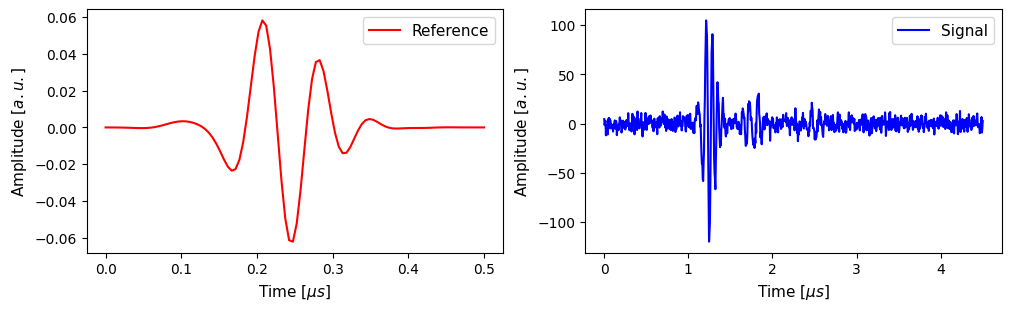

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import Deconvolution
from scipy.linalg import toeplitz
from scipy.io import loadmat

# Import reference
Reference = loadmat('Data/UT.mat')['ref'].squeeze()
Signal = loadmat('Data/AScanUT.mat')['prova'].squeeze()

# Create time vectors
dt = 5e-9
tR = np.linspace(0,len(Reference)*dt,len(Reference))*1e6
tS = np.linspace(0,len(Signal)*dt,len(Signal))*1e6

# Plot reference, impulse response and noisy signal
plt.figure(figsize=(10,3),constrained_layout=True)
plt.subplot(121)
plt.plot(tR,Reference,label='Reference',color='red')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.subplot(122)
plt.plot(tS,Signal,label='Signal',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## <mark>**Orthogonal Matching Pursuit (OMP)**</mark>
Orthogonal Matching Pursuit (OMP) is a greedy algorithm used for sparse signal reconstruction. It aims to represent a signal as a linear combination of a small number of basis (or dictionary) vectors. For a detailed description of the method, refer to **Algorithm 1** in the aforementioned paper.

#### ***Input***
<code>**Measured signal**: Signal</code>

<code>**Dictionary**: X</code>

<code>**Number of iterations**: N</code>

#### ***Output***
<code>**Vector of amplitudes**: aOMP</code>

<code>**Vector of ToF’s**: tOMP</code>

<code>**Estimated impulse response**: hOMP</code>

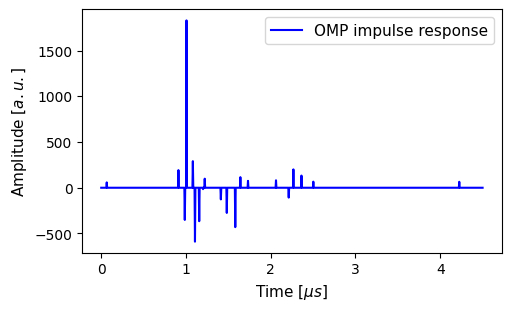

In [2]:
# Initialize parameters
Ns = len(Signal)
Nw = len(Reference)
X = toeplitz(np.r_[Reference, np.zeros(Ns-Nw)],np.r_[Reference[0], np.zeros(Ns-1)])
N = 20

aOMP,tOMP,hOMP = Deconvolution.OMP(Signal,X,N)

# Plot OMP results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hOMP,label='OMP impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## <mark>**ℓ1-norm deconvolution: Sparse Deconvolution (SD)**</mark>
ℓ1-norm sparse deconvolution is a signal processing technique used to recover a sparse signal from a measurement. It assumes that the underlying true signal is sparse —that is, it has only a few non-zero elements— and aims to estimate it by solving an optimization problem. For a detailed description of the method, refer to **Algorithm 2** in the aforementioned paper.

#### ***Input***
<code>**Measured signal**: Signal</code>

<code>**Reference signal**: Reference</code>

<code>**Step size gradient**: theta</code>

<code>**Penalty parameter**: lambda</code>

<code>**Number of iterations**: N_iter</code>

#### ***Output***
<code>**Estimated impulse response**: hSD</code>

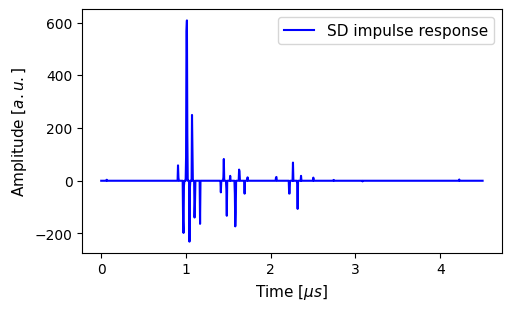

In [3]:
# Initialize parameters
Ns = len(Signal)
Nw = len(Reference)
X = toeplitz(np.r_[Reference, np.zeros(Ns-Nw)],np.r_[Reference[0], np.zeros(Ns-1)])
theta = 1/np.linalg.norm(X@X.T,2)
lam = 2
N_iter = 500

hSD = Deconvolution.SD(Signal,Reference,theta,lam,N_iter)

# Plot SD results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hSD,label='SD impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## <mark>**MUltiple SIgnal Classification (MUSIC)**</mark>
Multiple Signal Classification (MUSIC) is commonly applied when the estimated impulse response is modeled as a sum of delayed echoes. MUSIC identifies sparse signal structure by forming a covariance matrix, separating signal and noise subspaces via eigen-decomposition, and exploiting their orthogonality to locate underlying components. For a detailed description of the method, refer to **Algorithm 3** in the aforementioned paper.

#### ***Input***
<code>**Measured signal**: Signal</code>

<code>**Reference signal**: Reference</code>

<code>**Dimension of the signal subspace**: NSub</code>

<code>**Bandwidth percentage**: BW</code>

#### ***Output***
<code>**Vector of amplitudes**: aMUSIC</code>

<code>**Vector of ToF’s**: tMUSIC</code>

<code>**Estimated impulse response**: hMUSIC</code>

***Please note!***
The high-SNR region in this algorithm is defined as a percentage of the maximum magnitude of the reference signal's spectrum. Specifically, the lower frequency bound is the frequency at which the spectral magnitude drops below a specified percentage (BW) of the maximum, on the left side of the peak. Similarly, the upper frequency bound is the frequency where the magnitude falls below the same percentage on the right side of the peak.

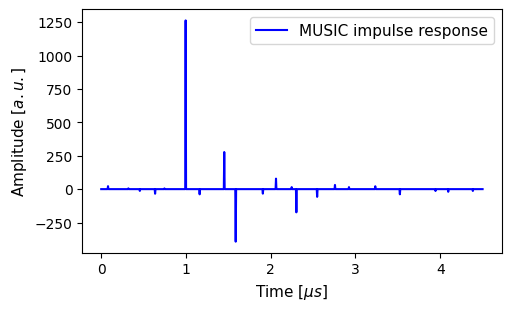

In [4]:
# Initialize parameters
NSub = 10
BW = 0.1

aMUSIC,tMUSIC,hMUSIC = Deconvolution.MUSIC(Signal,Reference,NSub,BW)

# Plot MUSIC results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS,hMUSIC,label='MUSIC impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

## <mark>**Autoregressive spectral extrapolation (AR)**</mark>
Autoregressive spectral extrapolation (AR) is a technique used in deconvolution to extend or enhance the frequency content of a measured signal. The method is based on modeling the signal’s spectrum using an autoregressive (AR) process. For a detailed description of the method, refer to **Algorithm 4** in the aforementioned paper.

#### ***Input***
<code>**Measured signal**: Signal</code>

<code>**Reference signal**: Reference</code>

<code>**Order of the autoregressive model**: p</code>

<code>**Bandwidth percentage**: BW</code>

#### ***Output***
<code>**Estimated impulse response**: hAR</code>

***Please note!***
The high-SNR region in this algorithm is defined as a percentage of the maximum magnitude of the reference signal's spectrum. Specifically, the lower frequency bound is the frequency at which the spectral magnitude drops below a specified percentage (BW) of the maximum, on the left side of the peak. Similarly, the upper frequency bound is the frequency where the magnitude falls below the same percentage on the right side of the peak.

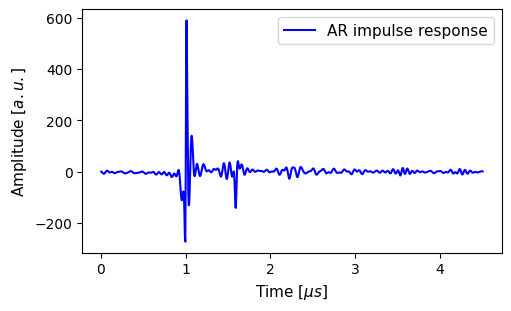

In [5]:
# Initialize parameters
BW = 0.3
p = 10

hAR = Deconvolution.AR(Signal,Reference,p,BW)

# Plot AR results
plt.figure(figsize=(5,3),constrained_layout=True)
plt.plot(tS[1:],hAR,label='AR impulse response',color='blue')
plt.xlabel(r'Time $[\mu s]$',fontsize=11)
plt.ylabel(r'Amplitude $[a.u.]$',fontsize=11)
plt.legend(fontsize=11)
plt.show()

For more information refer to the article:

*Zito, R., Shi, H. et al. - 'Stratigraphic reconstruction from terahertz and ultrasonic signals by deconvolution: a review'*